In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore')

md = pd.read_excel("./buffer/1-main_dataset.xlsx")
md.drop(columns=md.columns[0], axis=1, inplace=True)

X = md.drop(columns="Attrition", axis=1)
y = [i == "Yes" for i in md["Attrition"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,  random_state=0)


In [72]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Get the list of columns depending on there type
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='median')),
      ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
      ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
      ('num', numeric_transformer, numeric_features),
      ('cat', categorical_transformer, categorical_features)])

full_pipeline = Pipeline(steps=[
      ('preprocessor', preprocessor),
      ('modelRF', RandomForestClassifier())])

In [74]:
full_pipeline.fit(X_train, y_train)
y_predicted = full_pipeline.predict(X_test)
full_pipeline.score(X_test, y_test)

0.9852607709750567

In [82]:
def variation(model: Pipeline, X: pd.DataFrame, param: str, divi = 15):
    global y_predicted
    # Copy of the datasets for translating the values
    X_p = X.copy()
    X_m = X.copy()

    # Finding the translation amount
    maxi = max(X[param])
    mini = min(X[param])
    alpha = ( maxi - mini ) / divi

    # Translating the parameter
    X_p[param] += np.array([alpha]*len(X[param]))
    X_m[param] -= np.array([alpha]*len(X[param]))
    
    # Flooring and ceilling the parametes
    X_p[param].where(X_p[param] > maxi, maxi, inplace=True)
    X_p[param].where(X_p[param] < mini, mini, inplace=True)

    # Get the prediciton with the new model
    y_p_predicted = model.predict(X_p)
    y_m_predicted = model.predict(X_m)

    # Get the number of peaple that attritioned
    y_score = sum(y_predicted) * 100 / len(y_predicted)
    y_p_score = sum(y_p_predicted) * 100 / len(y_p_predicted)
    y_m_score = sum(y_m_predicted) * 100 / len(y_m_predicted)

    return (
        (y_score - y_p_score),
        (y_score - y_m_score)
    )

In [139]:
def variation(model: Pipeline, X: pd.DataFrame, param: str, divi = 15):
    global y_predicted
    # Copy of the datasets for translating the values
    X = X.copy()

    # Finding the translation amount
    maxi = max(X[param])
    mini = min(X[param])
    alpha = ( (maxi-mini) - (mini-maxi) ) / divi

    y_score = sum(y_predicted) * 100 / len(y_predicted)
    best_score = (y_score, 0)
    for delta in np.arange(mini-maxi, maxi-mini, alpha):
        # Translating the parameter
        X[param] += np.array( [delta] * len(X[param]) )

        # Flooring and ceilling the parametes
        X[param].where(X[param] > maxi, maxi, inplace=True)
        X[param].where(X[param] < mini, mini, inplace=True)

        # Get the prediciton with the new model
        y_local_predicted = model.predict(X)

        # Get the number of peaple that attritioned
        y_local_score = sum(y_local_predicted) * 100 / len(y_local_predicted)

        if y_local_score < best_score[0]:
            best_score = ( y_local_score, delta )

    return best_score

In [140]:

dict_var = {}
for column in X_test.columns:
    if column in numeric_features:
        dict_var[column] = variation(full_pipeline, X_test, column)


In [141]:
list_var = []
for i in range(2):
    list_var.append([j[i] for j in dict_var.values()])
print(list_var)
pd.DataFrame(columns=dict_var.keys(), data=list_var)

[[13.492063492063492, 13.945578231292517, 14.965986394557824, 14.965986394557824, 14.399092970521542, 14.058956916099774, 13.718820861678005, 14.852607709750567, 14.512471655328799, 14.965986394557824, 12.811791383219955, 14.285714285714286, 13.832199546485262, 13.718820861678005, 14.739229024943311, 13.945578231292517, 14.285714285714286, 14.965986394557824, 7.142857142857143, 14.965986394557824, 14.17233560090703], [-41.0, -28.0, 0, 0, -189900.0, -9.0, -14.0, -3.0, -40.0, 0, -40.0, -15.0, -17.0, -3.0, -3.0, -3.0, -3.0, 0, -0.21013336878472233, 0, -6751.589079602407]]


,Age,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,...,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Average,nb days off,Standard deviation
0,13.492063,13.945578,14.965986,14.965986,14.399093,14.058957,13.718821,14.852608,14.512472,14.965986,...,14.285714,13.8322,13.718821,14.739229,13.945578,14.285714,14.965986,7.142857,14.965986,14.172336
1,-41.000000,-28.000000,0.000000,0.000000,-189900.000000,-9.000000,-14.000000,-3.000000,-40.000000,0.000000,...,-15.000000,-17.0000,-3.000000,-3.000000,-3.000000,-3.000000,0.000000,-0.210133,0.000000,-6751.589080


TypeError: object of type 'AxesSubplot' has no len()

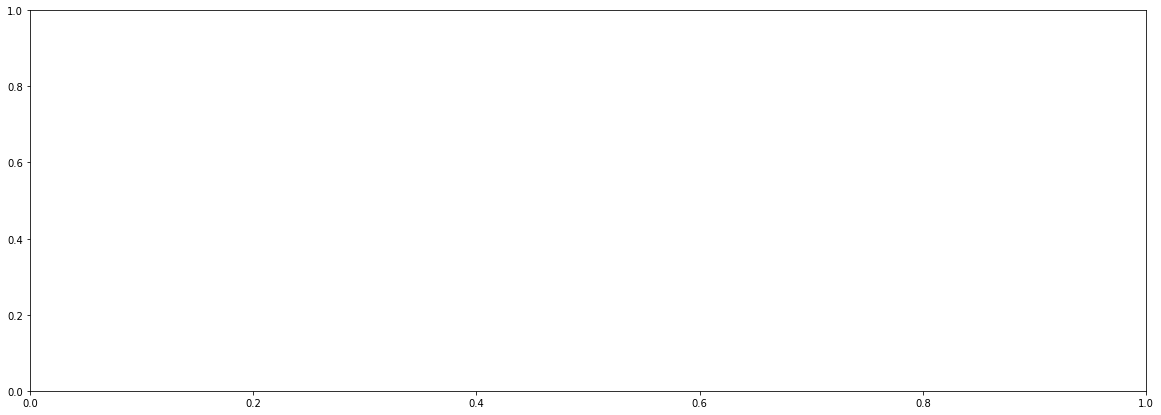

In [99]:
dict_var = {k: v for k, v in dict_var.items() if v[0] != 0 and v[1] != 0}

graph_l = dict_var.keys()
y_pos = np.arange(len(graph_l))

fig, axs = plt.subplots(1, 2, figsize=(20, 7))

for i in range(len(axs)):
    graph_x = [j[i] for j in dict_var.values()]
    axs[i].barh(y_pos, graph_x)
    axs[i].set_yticks(y_pos, labels=graph_l)
    axs[i].invert_yaxis()
    axs[i].set_xlabel('Attrition gap with control prediction')
    axs[i].set_title('Negative direction' if i == 0 else 'Positive direction')

fig.tight_layout()
plt.show()